In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
import math

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [3]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='E':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

#sliceOrientation: h means this function is taking a horizontal slice, and v means this function is taking a vertical 
#slice. 
def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/beam_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

def readPickleFile (pol, freqInd): #write the documentation for this 
    picklefile = beamdir+'Beamcoadd_pol_'+pol+'_freq_'+str(good_freqs[freqInd])+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    return ptest 

def turnPickle (flight, freq):
    pol, pols, cpols, attn, fi = get_flightinfo(flight)
    print (pol,pols,cpols,attn,fi)
    with open(glob.glob(pckldir+'*'+flight+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on   
    print (gfitarr[fi])
    find=good_freqs[freq]
    beam1=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                     normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                     Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find)
    return beam1


In [4]:
################################################################################################
######## 1. Read in some particular frequency, polarization 2D co-added beam ################
################################################################################################

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']




['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz']


/tmp/ipykernel_176092/2940412915.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('gnuplot2')


In [5]:
# pick your polarization and frequency

print(good_freqs)
# ask why this where isn't working for me -- print(np.where(good_freqs == '561')[0])

# set which pol:
copoldir = 'E'
polsE = E_pols
polsN = N_pols
find = good_freqs[0]
f_intern = 0 # only one frequency per file, this is always 0
print(polsN)
print (freqs[good_freqs[94]])

for i in range (len(good_freqs)):
    print (good_freqs[i], i)

[538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 599, 630, 631, 633, 645, 676, 691, 692, 693, 696, 697, 698, 699, 700, 705, 707, 720, 768, 799, 807, 814, 845, 846, 848, 849, 850, 851, 854, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 871, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 887, 888, 889, 890, 891, 893, 894, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 935, 938]
[1, 3, 9, 11, 15]
448.046875
538 0
553 1
554 2
555 3
556 4
557 5
558 6
560 7
561 8
562 9
563 10
564 11
565 12
566 13
567 14
568 15
569 16
571 17
572 18
573 19
575 20
576 21
577 22
578 23
579 24
580 25
581 26
582 27
583 28
584 29
599 30
630 31
631 32
633 33
645 34
676 35
691 36
692 37
693 38
696 39
697 40
698 41
699 42
700 43
705 44
707 45
720 46
768 47
799 48
807 49
814 5

In [7]:



#calculating the Gaussian -- 

#This function calculates the value of a 2D gaussian with user fed parameters for every point in a list of x-y coordinates. 
# parameters: 
#     P- a vector with amp0, x00, xsig0, y00, ysig0, and bg 0
#     x_coords- array of x coordinates, 1D numpy array
#     y_coords- array of y coordinates, 1D numpy array
# returns: 
#     results- 1D numpy array, each entry is the gaussian value assocaited with the x and y coordinates at the same index in the respective y and x coordinate lists 
def gaussianResultArray (P, x_coords, y_coords):
    results = np.empty(x_coords.size)
    i = 0
    while i < x_coords.size:
        results[i] = fu.Gauss_2d_LC_func(P, x_coords[i], y_coords[i])
        i = i + 1
    return results

#This function graphs the 2D gaussian fit over a grid of specified x and y coordinates. The fit value is displayed by color. 
# parameters: 
#     P- a vector with amp0, x00, xsig0, y00, ysig0, and bg 0
#     x_coords- array of x coordinates, 1D numpy array
#     y_coords- array of y coordinates, 1D numpy array
# returns nothing 
def graphGaussianResults (P, x_coords, y_coords): 
    fig, ax1 = subplots(nrows=1, ncols=1, figsize = (10,10))
    c = gaussianResultArray(P,x_coords, y_coords)
    im1=ax1.scatter(x_coords, y_coords, c=c, vmin=0, vmax=1, s=30)
    ax1.set_xlim(-sz,sz)
    ax1.set_ylim(-sz,sz)
    ax1.set_xlabel("X Position m")
    ax1.set_ylabel("Y Position m")
    divider=make_axes_locatable(ax1)
    cax=divider.append_axes("right", size="3%", pad = 0.05)
    cbar=fig.colorbar(im1, cax=cax)
    ax1.set_title('Aproximation')
    tight_layout()
    
def getSliceGauss(gaussArray, ax):
    if ax == 'v':
        sliceIndexes = np.where((mbx < (0+3)) & (mbx> (0)))[0]
    else:
        sliceIndexes = np.where((mby<(0+3)) & (mby> (0)))[0]
    slicey = np.empty((3, sliceIndexes.size))
    slicey[0,:] = mbx[sliceIndexes]
    slicey[1,:] = mby[sliceIndexes]
    slicey[2,:] = gaussArray[sliceIndexes]
    return slicey


#restrict to specific small range --suffer suffer suffer--
def getAverageResiduals(gaussArray, initVArray, ch, x_coords, y_coords, polarizationStr, gooddata):
    if polarizationStr == 'N':
        chind = polsN[ch]
    else: 
        chind = polsE[ch] 
    valueArray=initVArray.V_LC_operation[:,:,0,chind].flatten()[gooddata]
    subArray = np.subtract(gaussArray[gooddata], valueArray)
    totSum = 0; 
    countCount = 0;
    #numpy sum 
    for i, chind in enumerate (subArray):
        if ((x_coords[gooddata][i] > -20) & (x_coords[gooddata][i] < 20) & (y_coords[gooddata][i] > -20) & (y_coords[gooddata][i] < 20)):
            totSum += subArray[i]
            countCount += 1;
    return (totSum / countCount)

def getResidualVarience (gaussArray, initVArray, ch, x_coords, y_coords, polarizationStr, gooddata):
    if polarizationStr == 'N':
        chind = polsN[ch]
    else: 
        chind = polsE[ch]
    valueArray=initVArray.V_LC_operation[:,:,0,chind].flatten()[gooddata]
    subArray = np.subtract(gaussArray[gooddata], valueArray)
    totSum = 0; 
    countCount = 0;
    #numpy sum 
    for i, chind in enumerate (subArray):
        if ((x_coords[gooddata][i] > -20) & (x_coords[gooddata][i] < 20) & (y_coords[gooddata][i] > -20) & (y_coords[gooddata][i] < 20)):
            totSum += subArray[i] ** 2
            countCount += 1;
    return (totSum / countCount)

def getResidualsSTDEV(gaussArray, initVArray, ch, x_coords, y_coords, polarizationStr, gooddata):
    if polarizationStr == 'N':
        chind = polsN[ch]
    else: 
        chind = polsE[ch]
    valueArray=initVArray.V_LC_operation[:,:,0,chind].flatten()[gooddata]
    subArray = np.subtract(gaussArray[gooddata], valueArray)
    totSum = 0; 
    countCount = 0;
    #numpy sum 
    for i, chind in enumerate (subArray):
        if ((x_coords[gooddata][i] > -20) & (x_coords[gooddata][i] < 20) & (y_coords[gooddata][i] > -20) & (y_coords[gooddata][i] < 20)):
            totSum += subArray[i] ** 2
            countCount += 1;
    return math.sqrt(totSum / countCount)

def getEllipticity (x_array, y_array):
    result = np.zeros(len(x_array))
    for i in range (len(x_array)):
        result[i] = (x_array[i]-y_array[i])*2/(x_array[i]+y_array[i])
    return results 
    
     




In [8]:
#looking at the stepping data points and seeing why they do that thing 

amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])

lowFreq = readPickleFile('N', 94 )
higherFreq = readPickleFile('N', 122)
mbxlow = lowFreq.x_centers_grid[:,:,0].flatten()
mbylow = lowFreq.y_centers_grid[:,:,0].flatten()
mbVlow = lowFreq.V_LC_operation[:,:,0,11].flatten()
mbxHigh = higherFreq.x_centers_grid[:,:,0].flatten()
mbyHigh = higherFreq.y_centers_grid[:,:,0].flatten()
mbVHigh = higherFreq.V_LC_operation[:,:,0,11].flatten()
gooddatalow = np.isfinite(mbVlow)
gooddataHigh = np.isfinite(mbVHigh)
input_data_l=np.array([mbxlow[gooddatalow],mbylow[gooddatalow],mbVlow[gooddatalow]])
input_data_h=np.array([mbxHigh[gooddataHigh],mbyHigh[gooddataHigh],mbVHigh[gooddataHigh]])
G_popt_l=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data_l).x
G_popt_h=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data_h).x

gaussL= gaussianResultArray(G_popt_l, mbxlow, mbylow)
guassH= gaussianResultArray(G_popt_h, mbxHigh, mbyHigh)

#Plotting an Horizontal Slice 
horizontalGaussSliceL = getSliceGauss(gaussL, 'h')
horizontalGaussSliceH = getSliceGauss(guassH, 'h')
horizontalIndexL = get_slice(lowFreq,lowFreq.V_LC_operation[:,:,0,11],1.25,'h')
horizontalIndexH = get_slice(higherFreq,higherFreq.V_LC_operation[:,:,0,11],1.25,'h')
fig = plt.figure(figsize=(15,10))
plt.scatter(lowFreq.x_centers_grid[:,horizontalIndexL[0],0],lowFreq.V_LC_operation[:,horizontalIndexL[0],0,11], c = 'blue', label = 'Data 448' )
plt.scatter(higherFreq.x_centers_grid[:,horizontalIndexH[0],0],higherFreq.V_LC_operation[:,horizontalIndexH[0],0,11], c = 'black', label ='Data 435')
plt.scatter(horizontalGaussSliceL[0, :], horizontalGaussSliceL[2, :], c = 'red', label = 'Fit 448')
plt.scatter(horizontalGaussSliceH[0, :], horizontalGaussSliceH[2, :], c = 'green', label ='Fit 435')
plt.title('Input Y = 1.25')
plt.ylim(-1,1)
plt.xlim(-20,20)
plt.legend()
plt.show()
    
    
    
'''    
verticalIndex = get_slice(ptest,ptest.V_LC_operation[:,:,0,11],1.25,'v')
verticalGaussSliceL = getSliceGauss(gaussL, 'v')
verticalGaussSliceH = getSliceGauss(gaussH, 'v') 
#Plotting a vertical slice 
fig = plt.figure(figsize=(15,10))
plt.scatter(ptest.y_centers_grid[verticalIndex[0],:,0],ptest.V_LC_operation[verticalIndex[0],:,0,11], c = 'blue')
plt.scatter(verticalGaussSlice[1, :], verticalGaussSlice[2, :], c = 'red')
plt.scatter(verticalGaussSlice[1, :], verticalGaussSlice[2, :], c = 'red')
plt.ylim(-1,1)
plt.xlim(-20,20)
plt.title('Input X = 1.25: '+str(freqs[good_freqs[i]]))
plt.legend()
plt.show()
'''

NameError: name 'mby' is not defined

/hirax/GBO_Analysis_Outputs/beam_pickles/


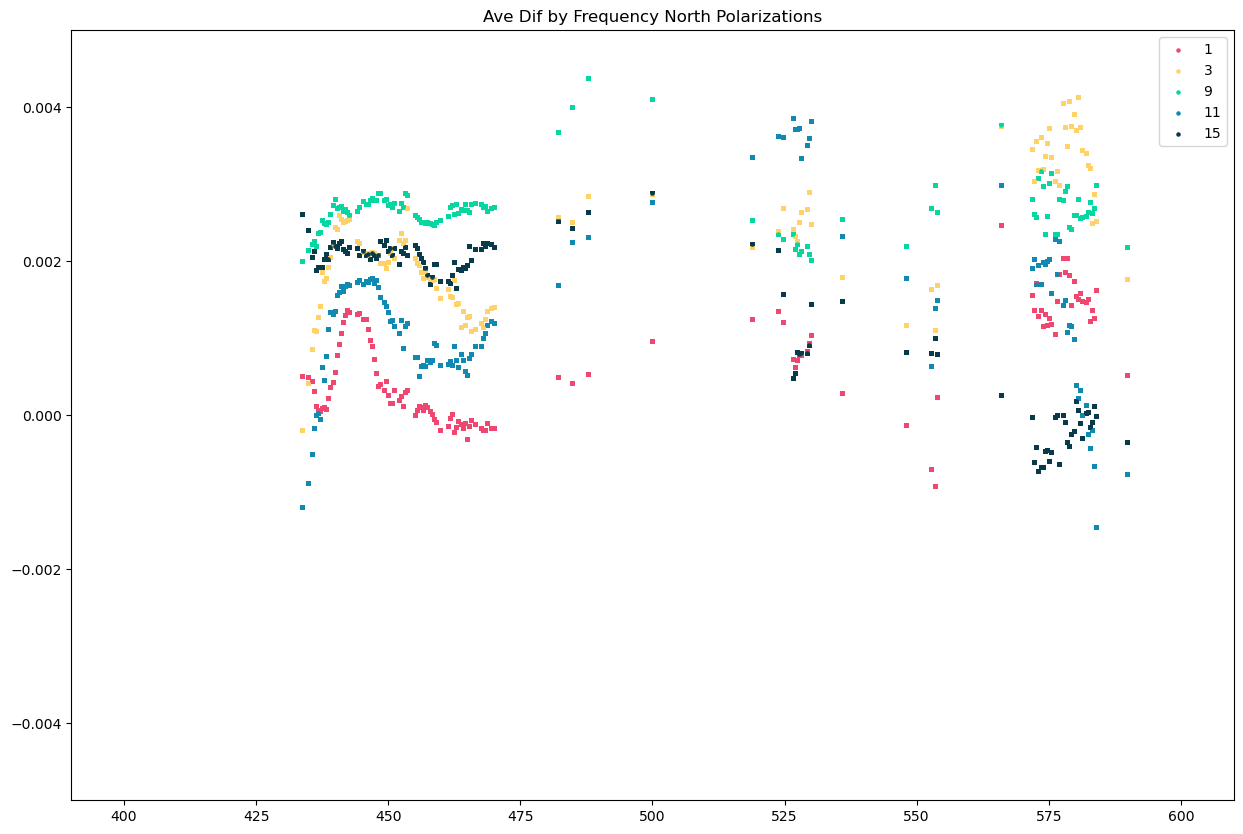

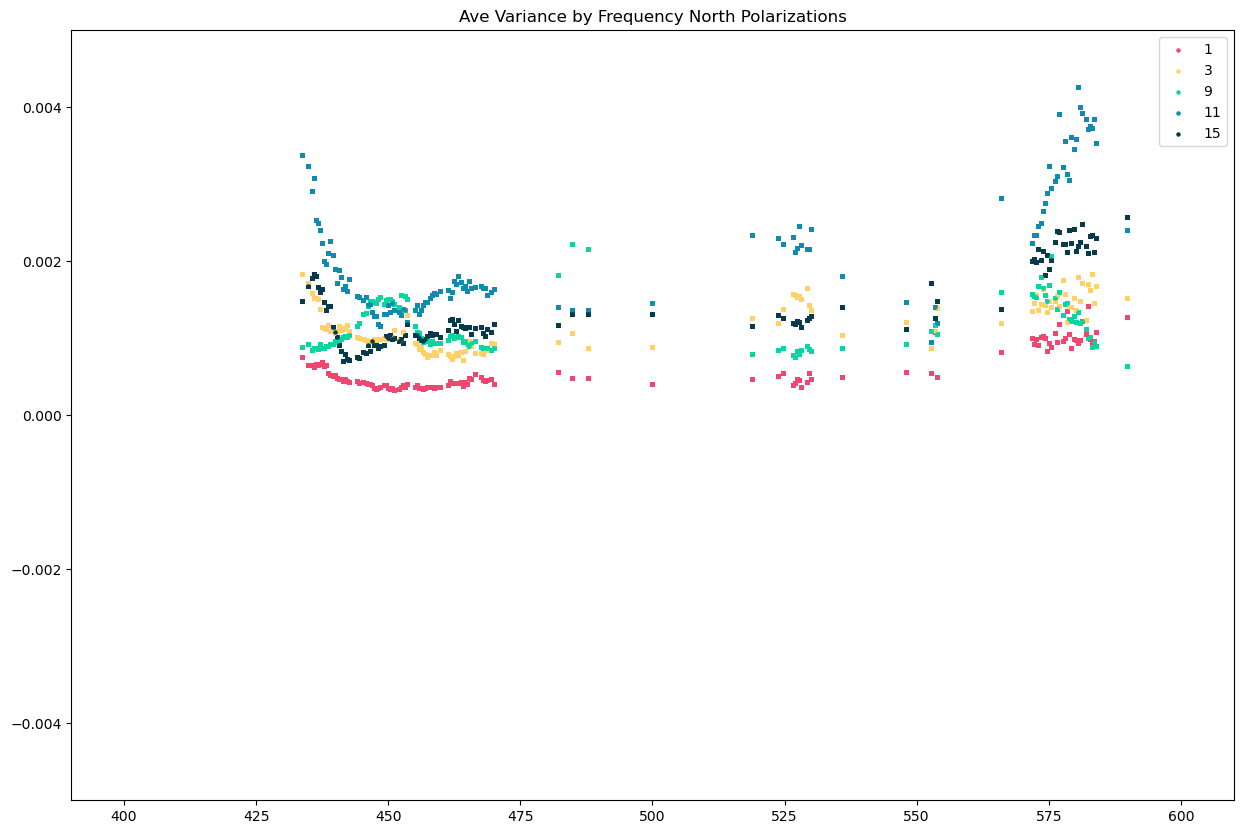

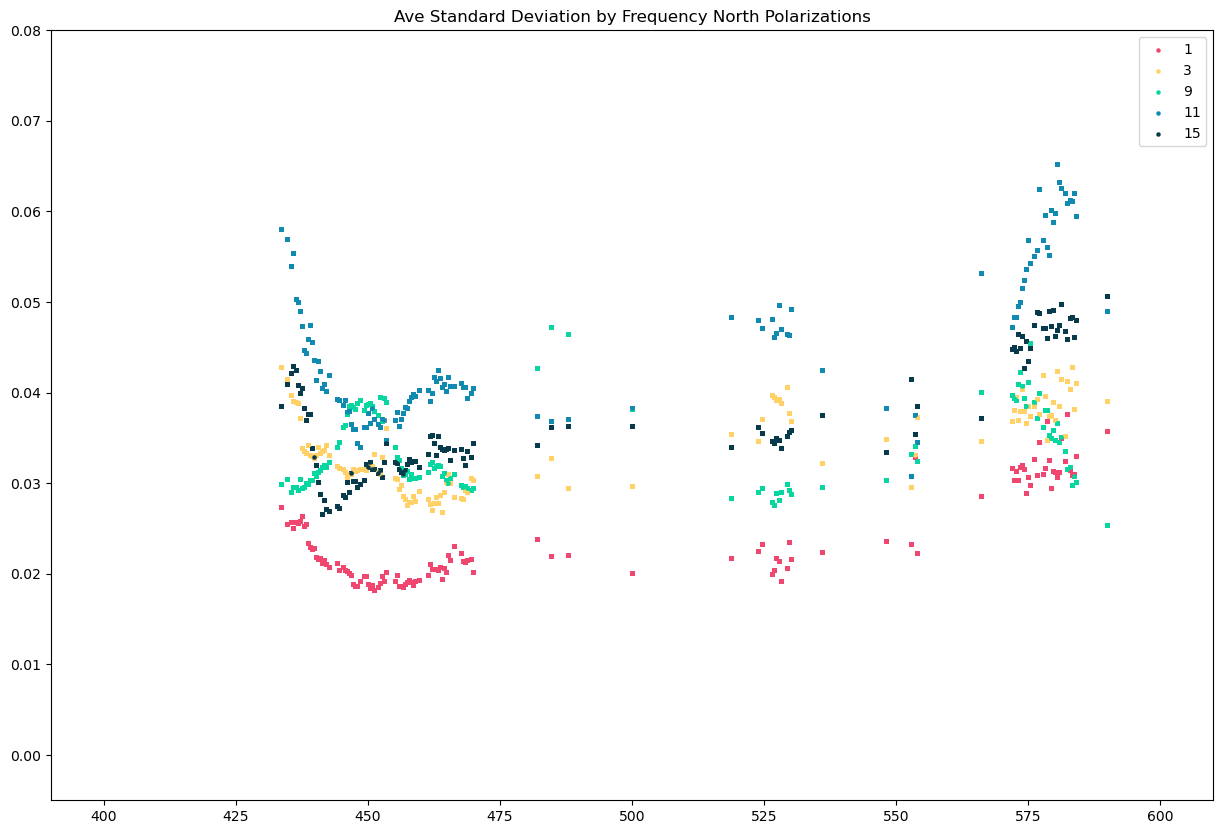

/hirax/GBO_Analysis_Outputs/beam_pickles/


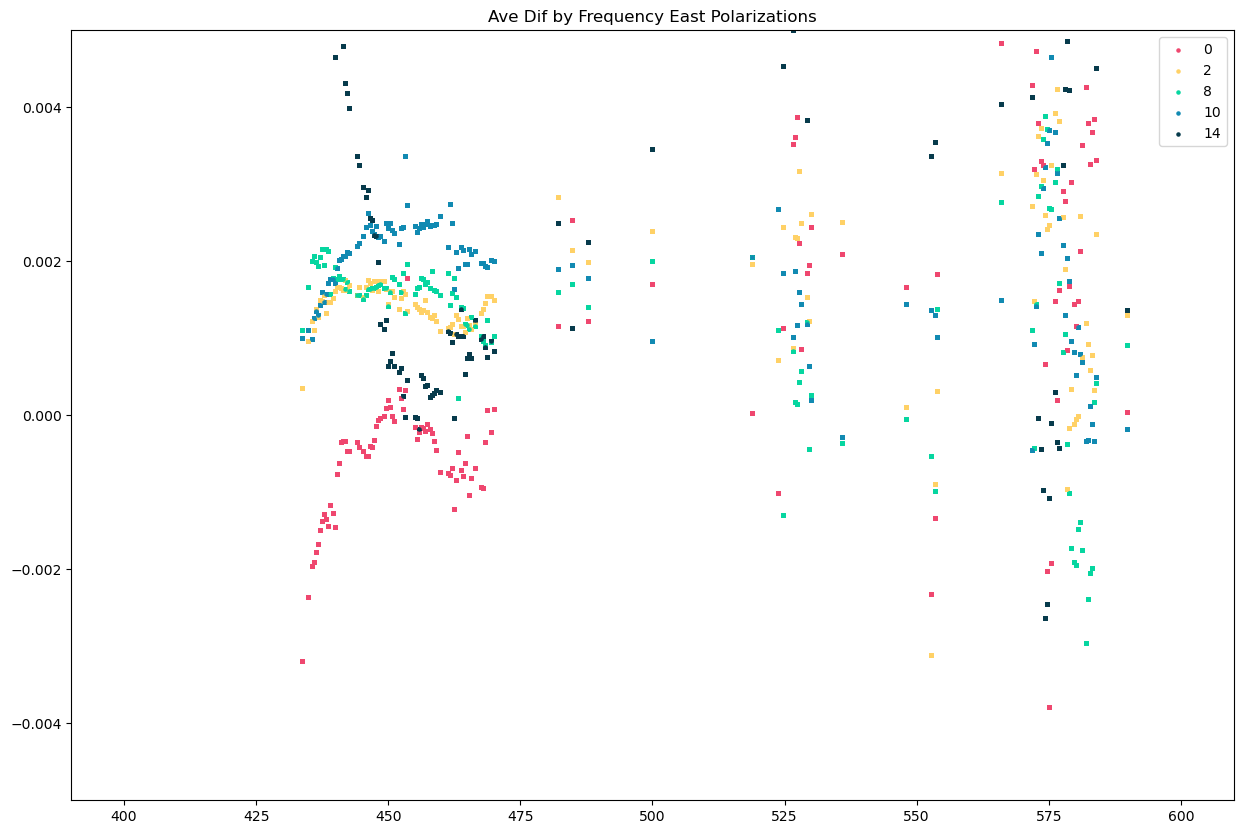

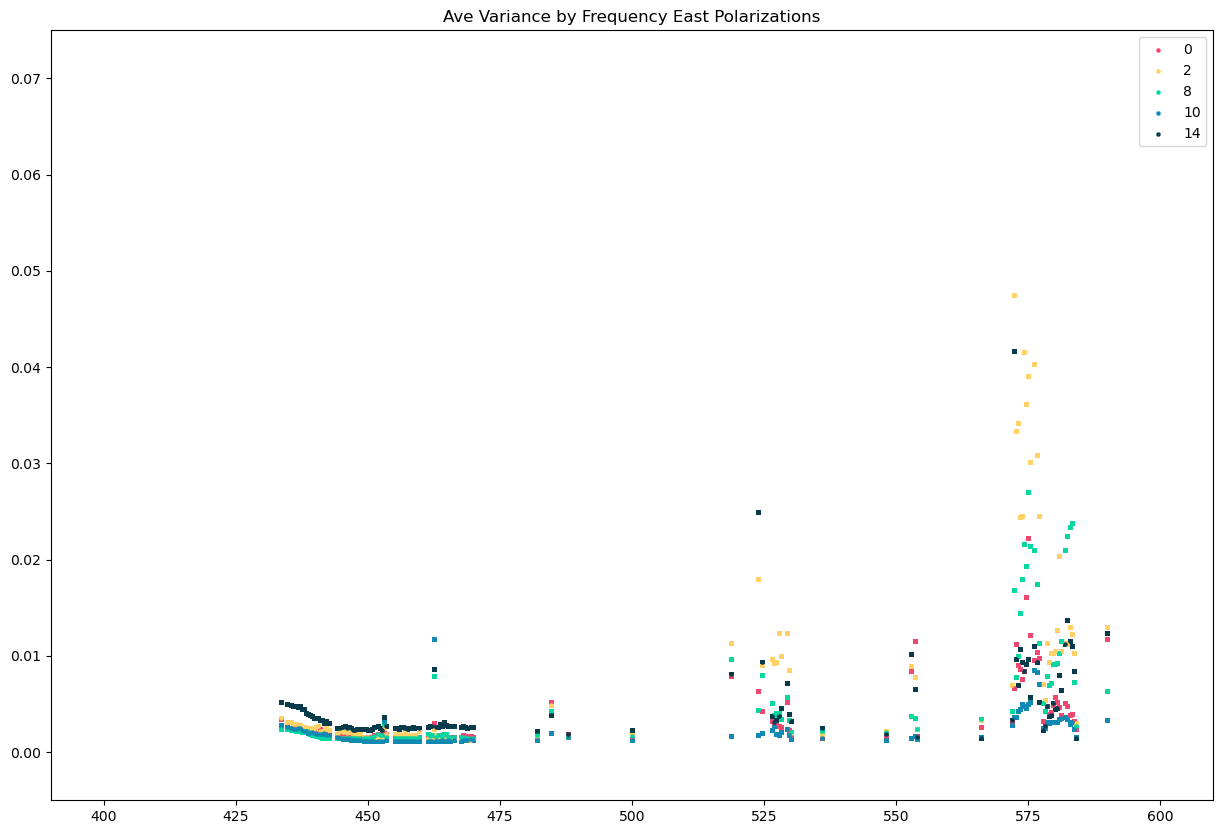

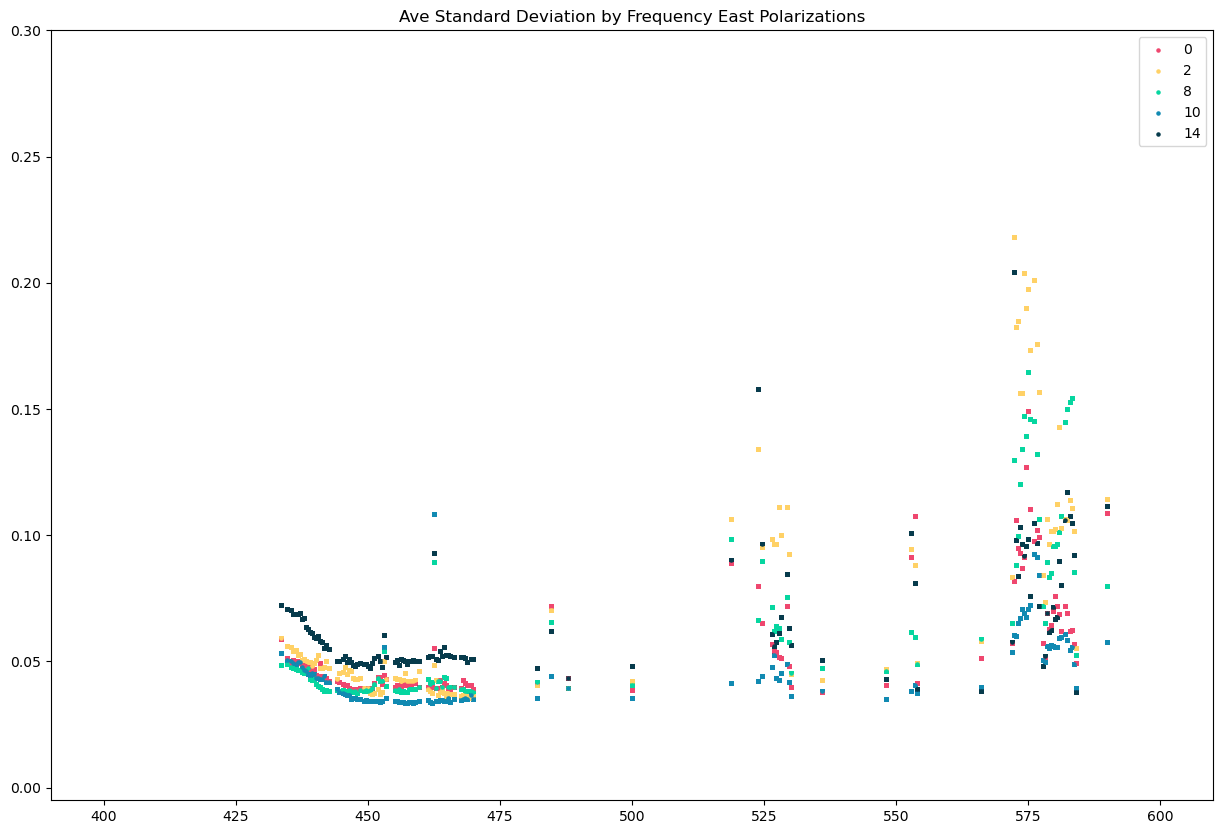

In [9]:
###### North Polarizations ######

# Steps: 
# 1) Calculate the Gaussian for every channel for every frequency
# 2) Calculate the difference for every channel
# 3) Make an array of the difference and the frequency 
# 4) Plot the above array


amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
print(beamdir)
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
northPolArrayMain = np.zeros((len(good_freqs), len(N_pols),1))
northPolVarArray = np.zeros((len(good_freqs), len(N_pols),1))
northPolStDeVArray = np.zeros((len(good_freqs), len(N_pols),1))
northFitValArray = np.zeros((len(good_freqs), len(N_pols),5))
for f, freqVal in enumerate (good_freqs):    
    for i, value in enumerate (N_pols):
        droneData = readPickleFile ('N', f)
        mbx = droneData.x_centers_grid[:,:,0].flatten()
        mby = droneData.y_centers_grid[:,:,0].flatten()
        mbV = droneData.V_LC_operation[:,:,0,value].flatten()
        gooddata = np.isfinite(mbV)
        input_data=np.array([mbx[gooddata],mby[gooddata],mbV[gooddata]])
        G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        for g in range(5):
            northFitValArray[f, i, g]=G_popt[g]
        gaussianEstimateArray = gaussianResultArray (G_popt, mbx, mby)
        northPolArrayMain[f,i,0] = getAverageResiduals(gaussianEstimateArray, droneData, i, mbx, mby, 'N', gooddata)
        northPolVarArray[f,i,0] = getResidualVarience(gaussianEstimateArray, droneData, i, mbx, mby, 'N', gooddata)
        northPolStDeVArray[f,i,0] = getResidualsSTDEV(gaussianEstimateArray, droneData, i, mbx, mby, 'N', gooddata)
        

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(northPolArrayMain):
    for i, chind in enumerate (northPolArrayMain[j,:,0]):
        if N_pols[i] == 1: 
            c = '#ef476f'
        elif N_pols[i] == 3:
            c = '#ffd166'
        elif N_pols[i] == 9:
            c = '#06d6a0'
        elif N_pols[i] == 11:
            c = '#118ab2'
        else: 
            c = '#073b4c'
        if j == 0:
            plt.scatter(freqs[good_freqs], northPolArrayMain[:,i,0], c=c, s=5, label = N_pols[i])
        else:
            plt.scatter(freqs[good_freqs], northPolArrayMain[:,i,0], c=c, s=5)
        plt.title('Ave Dif by Frequency North Polarizations')
        plt.ylim(-0.005,0.005)
        plt.xlim(390,610)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(northPolArrayMain):
    for i, chind in enumerate (northPolArrayMain[j,:,0]):
        if N_pols[i] == 1: 
            c = '#ef476f'
        elif N_pols[i] == 3:
            c = '#ffd166'
        elif N_pols[i] == 9:
            c = '#06d6a0'
        elif N_pols[i] == 11:
            c = '#118ab2'
        else: 
            c = '#073b4c'
        if j == 0:
            plt.scatter(freqs[good_freqs], northPolVarArray[:,i,0], c=c, s=5, label=N_pols[i])
        else:
            plt.scatter(freqs[good_freqs], northPolVarArray[:,i,0], c=c, s=5)
        plt.title('Ave Variance by Frequency North Polarizations')
        plt.ylim(-0.005,0.005)
        plt.xlim(390,610)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(northPolArrayMain):
    for i, chind in enumerate (northPolArrayMain[j,:,0]):
        if N_pols[i] == 1: 
            c = '#ef476f'
        elif N_pols[i] == 3:
            c = '#ffd166'
        elif N_pols[i] == 9:
            c = '#06d6a0'
        elif N_pols[i] == 11:
            c = '#118ab2'
        else: 
            c = '#073b4c'
        if j == 0:
            plt.scatter(freqs[good_freqs], northPolStDeVArray[:,i,0], c=c, s=5, label = N_pols[i])
        else:
            plt.scatter(freqs[good_freqs], northPolStDeVArray[:,i,0], c=c, s=5)
        plt.title('Ave Standard Deviation by Frequency North Polarizations')
        plt.ylim(-0.005, 0.08)
        plt.xlim(390,610)
plt.legend()
plt.show()



###### East Polarizations ######
# 1) Calculate the Gaussian for every channel for every frequency
# 2) Calculate the difference for every channel
# 3) Make an array of the difference and the frequency 
# 4) Plot the above array

amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
print(beamdir)
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
eastPolArrayMain = np.zeros((len(good_freqs),len(E_pols), 1))
eastPolVarArray = np.zeros((len(good_freqs), len(N_pols),1))
eastPolStDeVArray = np.zeros((len(good_freqs), len(N_pols),1))
eastFitValArray = np.zeros((len(good_freqs), len(E_pols), 5))
for f, freqVal in enumerate (good_freqs):    
    for i, value in enumerate (E_pols):
        droneData = readPickleFile ('E', f)
        mbx = droneData.x_centers_grid[:,:,0].flatten()
        mby = droneData.y_centers_grid[:,:,0].flatten()
        mbV = droneData.V_LC_operation[:,:,0,value].flatten()
        gooddata = np.isfinite(mbV)
        input_data=np.array([mbx[gooddata],mby[gooddata],mbV[gooddata]])
        G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        for g in range(5):
            eastFitValArray[f, i, g]=G_popt[g]
        gaussianEstimateArray = gaussianResultArray (G_popt, mbx, mby)
        eastPolArrayMain[f,i,0] = getAverageResiduals(gaussianEstimateArray, droneData, i, mbx, mby,'E', gooddata)
        eastPolVarArray[f,i,0] = getResidualVarience(gaussianEstimateArray, droneData, i, mbx, mby, 'E', gooddata)
        eastPolStDeVArray[f,i,0] = getResidualsSTDEV(gaussianEstimateArray, droneData, i, mbx, mby, 'E', gooddata)


fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(eastPolArrayMain):
    for i, chind in enumerate (eastPolArrayMain[j,:,0]):
        if E_pols[i] == 0: 
            c = '#ef476f'
        elif E_pols[i] == 2:
            c = '#ffd166'
        elif E_pols[i] == 8:
            c = '#06d6a0'
        elif E_pols[i] == 10:
            c = '#118ab2'
        else: 
            c = '#073b4c'
        if j == 0:
            plt.scatter(freqs[good_freqs], eastPolArrayMain[:,i,0], c=c, s=5, label = E_pols[i])
        else:
            plt.scatter(freqs[good_freqs], eastPolArrayMain[:,i,0], c=c, s=5)
        plt.title('Ave Dif by Frequency East Polarizations')
        plt.ylim(-0.005,0.005)
        plt.xlim(390,610)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(northPolArrayMain):
    for i, chind in enumerate (northPolArrayMain[j,:,0]):
        if E_pols[i] == 0: 
            c = '#ef476f'
        elif E_pols[i] == 2:
            c = '#ffd166'
        elif E_pols[i] == 8:
            c = '#06d6a0'
        elif E_pols[i] == 10:
            c = '#118ab2'
        else: 
            c = '#073b4c'
        if j == 0:
            plt.scatter(freqs[good_freqs], eastPolVarArray[:,i,0], c=c, s=5, label = E_pols[i])
        else:
            plt.scatter(freqs[good_freqs], eastPolVarArray[:,i,0], c=c, s=5)
        plt.title('Ave Variance by Frequency East Polarizations')
        plt.ylim(-0.005,0.075)
        plt.xlim(390,610)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(northPolArrayMain):
    for i, chind in enumerate (northPolArrayMain[j,:,0]):
        if E_pols[i] == 0: 
            c = '#ef476f'
        elif E_pols[i] == 2:
            c = '#ffd166'
        elif E_pols[i] == 8:
            c = '#06d6a0'
        elif E_pols[i] == 10:
            c = '#118ab2'
        else: 
            c = '#073b4c'
        if j == 0:
            plt.scatter(freqs[good_freqs], eastPolStDeVArray[:,i,0], c=c, s=5, label = E_pols[i])
        else:
            plt.scatter(freqs[good_freqs], eastPolStDeVArray[:,i,0], c=c, s=5)
        plt.title('Ave Standard Deviation by Frequency East Polarizations')
        plt.ylim(-0.005,0.3)
        plt.xlim(390,610)
plt.legend()
plt.show()


[[ 8.24353487  8.90692557  8.35237942  8.9293165   8.34504603  8.93462511
   8.33065061  8.90501035  8.34412276  8.29036976  8.32412832  8.86322804
   8.30212542  8.30209116  8.83510513  8.83459999  8.80658145  8.80426914
   8.20674499  8.22064079  8.0877909   8.60897334  8.04335978  8.59717576
   8.588902    8.57399573  8.03607654  8.56986827  8.52968781  8.56092499
   8.54319273  7.97867779  8.09057207  8.26858679  8.57828208  8.62907474
   8.71620866  8.667242    8.65444911  8.54981061  8.55903398  8.55961729
   8.56375018  8.5638004   8.60781209  8.65084921  8.82779959  8.8831665
   8.92868397  8.99140938  9.10521658  9.5470293   9.55327451  9.50871709
   9.55438073  9.5449296   9.54792467  9.52481136  9.52556921  9.51895297
   9.49173332  9.53593383  9.45665166  9.46754103  9.46019826  9.49416988
   9.51563851  9.51636061  9.53242619  9.53756696  9.5535887   9.54347679
   9.53978994  9.52377631  9.52417199  9.52050927  9.51952201  9.52688392
   9.53545844  9.61791241  9.6437899   

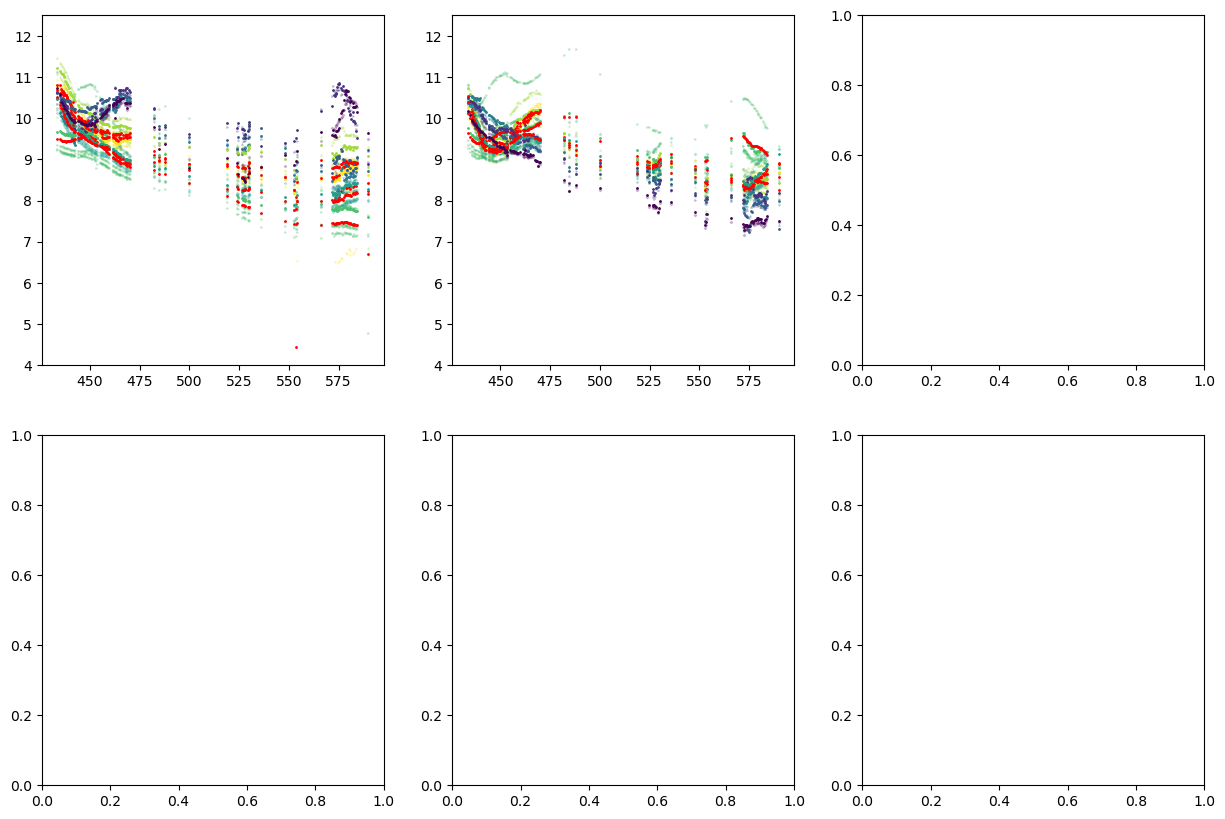

"\na = 0.8\nplt.figure(1,figsize=(15,15))\nplt.subplot(321)\np = 0\nfor f in range(0,len(flies)):\n    fly = flies[f]\n    ffile = glob.glob(fitdir+'*'+fly+'*')[0]\n    fits = np.load(ffile)\n    try:\n        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],\n                 linestyle='None',alpha=a,label=fly)\n        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],\n                 linestyle='None',alpha=a)\n    except:''\nplt.legend()\nplt.ylim(4,14)\nplt.ylabel('X&Y width [m]')\nplt.xlabel('Frequency [MHz]')\nplt.subplot(322)\np = 1\nfor f in range(0,len(flies)):\n    fly = flies[f]\n    ffile = glob.glob(fitdir+'*'+fly+'*')[0]\n    fits = np.load(ffile)\n    try:\n        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],\n                 linestyle='None',alpha=a)\n        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colo

In [10]:
################################################################################################
################# 3. Compare to the combination of individual flights #####################
################################################################################################

## N pol flights

flies = ['618','619','625','536','646', '647','533']
selectedFlies= ['618','619','625','536']
Npols = [1, 3, 9, 15]
Epols = [0, 2, 8, 10]
markers = ['v','^','>','P','x','+','o']
colorN=['#fde725','#a0da39','#4ac16d','#1fa187']
colorE=['#277f8e','#365c8d','#46327e','#440154']
p = 0


fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (15,10))

##First graph w/ x  sigmas and Second graph with 
for i in range (4):
    aveNorthSigArray=np.zeros((2,len(good_freqs)))
    for f in range(0,len(selectedFlies)):
        fly = selectedFlies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        ax[0,0].scatter(freqs[good_freqs],fits['G_popt'][Npols[i],good_freqs,2],marker=markers[i], s=1, color=colorN[i],linestyle='None', alpha = 0.3)
        ax[0,1].scatter(freqs[good_freqs],fits['G_popt'][Npols[i],good_freqs,4],marker=markers[i], s=1, color=colorN[i],linestyle='None', alpha = 0.3)
        aveNorthSigArray=np.add((fits['G_popt'][Npols[i],good_freqs,2],fits['G_popt'][Npols[i],good_freqs,4]), aveNorthSigArray)
    aveNorthSigArray=np.divide(aveNorthSigArray, 4)
    fly = '620'
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    ax[0,0].scatter(freqs[good_freqs],fits['G_popt'][Epols[i],good_freqs,2],marker=markers[i], s=1, color=colorE[i],linestyle='None', alpha = 0.3)
    ax[0,1].scatter(freqs[good_freqs],fits['G_popt'][Epols[i],good_freqs,4] ,marker=markers[i], s=1, color=colorE[i],linestyle='None', alpha = 0.3)
    if i == 3:
        ax[0,0].scatter(freqs[good_freqs], northFitValArray[:, i+1, 2], s=1, color = colorN[i], zorder=2, marker='o')
        ax[0,1].scatter(freqs[good_freqs], northFitValArray[:, i+1, 4], s=1, color = colorN[i], zorder=2, marker='o')
    else: 
        ax[0,0].scatter(freqs[good_freqs], northFitValArray[:, i, 2], s=1, color = colorN[i], zorder=2, marker='o')
        ax[0,1].scatter(freqs[good_freqs], northFitValArray[:, i, 4], s=1, color = colorN[i], zorder=2, marker='o')
        print(aveNorthSigArray)
    ax[0,0].scatter(freqs[good_freqs], aveNorthSigArray[0,:], s=1, color = 'red', zorder=2, marker='o')
    ax[0,1].scatter(freqs[good_freqs], aveNorthSigArray[1,:], s=1, color = 'red', zorder=2, marker='o')
    ax[0,0].scatter(freqs[good_freqs], eastFitValArray[:, i, 2], s=1, color = colorE[i], zorder=2, marker='o')
    ax[0,1].scatter(freqs[good_freqs], eastFitValArray[:, i, 4], s=1, color = colorE[i], zorder=2, marker='o')
   # ax[0,0].title('X Sigmas [m]')
  #  ax[0,1].title('Y Sigmas [m]')
   # ax[0,0].legend(fontsize=5)
   # ax[0,1].legend(fontsize=5)
   # ax[0,0].ylabel('X Sigmas [m]')
   # ax[0,0].xlabel('Frequency [MHz]')
   # ax[0,1].ylabel('X Sigmas [m]')
   # ax[0,1].xlabel('Frequency [MHz]')
    ax[0,0].set_ylim(4,12.5)
    ax[0,1].set_ylim(4,12.5)
plt.show()
    


'''   
# E pol flights

flies = ['620','648','649','535']
pols = E_pols
markers = ['s','v','^','>']
colors=['red','orange','yellow','green']
p = 0

for i in range (5):
    # X width
    fig = plt.figure(figsize=(8,6))
    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][polsE[i],:,2],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly, zorder=1)
    plt.scatter(freqs[good_freqs], eastFitValArray[:, i, 2], s=2, color = 'black', zorder=2, label = "Co-added")
    plt.title('X width [m] Dish ' + str (polsE[i]))
    plt.legend()
    plt.ylim(4,18)
    plt.show()

# Y width
for i in range (5):
    fig = plt.figure(figsize=(8,6))
    for f in range(0,len(flies)):
        fly = flies[f]
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        plt.plot(freqs,fits['G_popt'][polsE[i],:,4],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly, zorder=1)
    plt.scatter(freqs[good_freqs], eastFitValArray[:, i, 4], s=2, color = 'black', zorder=2, label = "Co-added")
    plt.title('Y width [m] Dish ' + str (pols[i]))
    plt.legend()
    plt.ylim(4,18)
    plt.show()   
''' 

'''
a = 0.8
plt.figure(1,figsize=(15,15))
plt.subplot(321)
p = 0
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a,label=fly)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.legend()
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(322)
p = 1
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(323)
p = 2
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(324)
p = 3
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(325)
p = 4
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.show()
'''


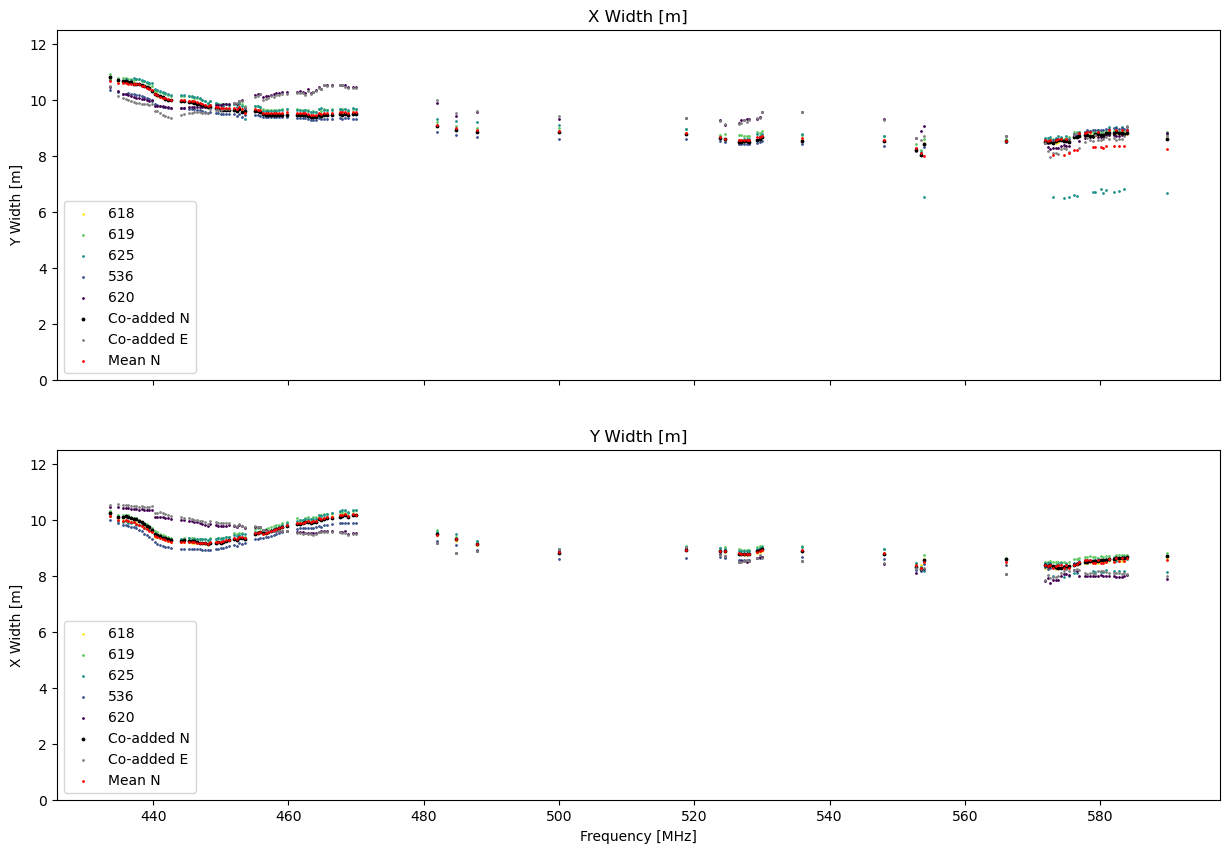

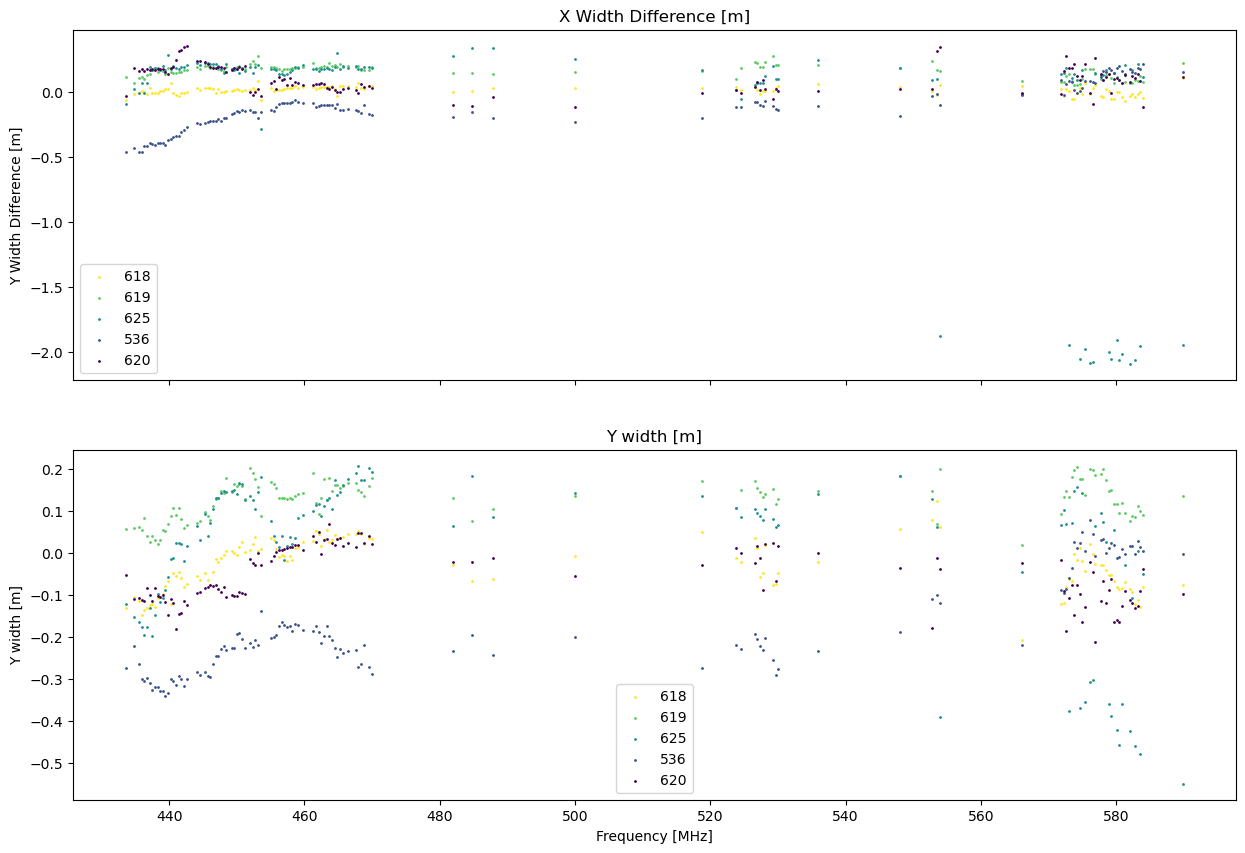

In [11]:
#graphinng just dish zero / one 
selectedFlies= ['618','619','625','536']
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (15,10))
aveNorthSigArray=np.zeros((2,len(good_freqs)))
colors = ['#fde725','#5ec962','#21918c','#3b528b','#440154']
fig, ax2 = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (15,10))
for f in range(0,len(selectedFlies)):
    fly = selectedFlies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    ax[0].scatter(freqs[good_freqs],fits['G_popt'][1,good_freqs,2], s=1, color=colors[f],linestyle='None', label = fly)
    ax[1].scatter(freqs[good_freqs],fits['G_popt'][1,good_freqs,4], s=1, color=colors[f],linestyle='None', label = fly)
    ax2[0].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][1,good_freqs,2], northFitValArray[:, 0, 2]), s=1, color=colors[f],linestyle='None', label = fly)
    ax2[1].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][1,good_freqs,4], northFitValArray[:, 0, 4]), s=1, color=colors[f],linestyle='None', label = fly)
    aveNorthSigArray=np.add((fits['G_popt'][1,good_freqs,2],fits['G_popt'][1,good_freqs,4]), aveNorthSigArray)
aveNorthSigArray=np.divide(aveNorthSigArray, 4)
fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits = np.load(ffile)

ax[0].scatter(freqs[good_freqs],fits['G_popt'][0,good_freqs,2], s=1, color=colors[4],linestyle='None', label = fly)
ax[1].scatter(freqs[good_freqs],fits['G_popt'][0,good_freqs,4], s=1, color=colors[4],linestyle='None', label = fly)
ax2[0].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][0,good_freqs,2],eastFitValArray[:, 0, 2]), s=1, color=colors[4],linestyle='None', label = fly)
ax2[1].scatter(freqs[good_freqs],np.subtract(fits['G_popt'][0,good_freqs,4],eastFitValArray[:, 0, 4]), s=1, color=colors[4],linestyle='None', label = fly)
ax[0].scatter(freqs[good_freqs], northFitValArray[:, 0, 2], s=3, color = 'black', marker='o', label = 'Co-added N')
ax[1].scatter(freqs[good_freqs], northFitValArray[:, 0, 4], s=3, color = 'black', marker='o', label = 'Co-added N')
ax[0].scatter(freqs[good_freqs], eastFitValArray[:, 0, 2], s=1, color = 'grey', zorder=2, marker='o', label = 'Co-added E')
ax[1].scatter(freqs[good_freqs], eastFitValArray[:, 0, 4], s=1, color = 'grey', zorder=2, marker='o', label = 'Co-added E')
ax[0].scatter(freqs[good_freqs], aveNorthSigArray[0,:], s=1, color = 'red', zorder=2, marker='o', label = 'Mean N')
ax[1].scatter(freqs[good_freqs], aveNorthSigArray[1,:], s=1, color = 'red', zorder=2, marker='o', label = 'Mean N')
ax[0].set_ylim(0,12.5)
ax[1].set_ylim(0,12.5)
ax[0].set_title('X Width [m]')
ax[1].set(xlabel = 'Frequency [MHz]', ylabel = 'X Width [m]')
ax[0].set(ylabel = 'Y Width [m]')
ax[1].set_title('Y Width [m]')
ax[1].legend()
ax[0].legend()

ax2[0].set_title('X Width Difference [m]')
ax2[1].set(xlabel = 'Frequency [MHz]', ylabel = 'Y width [m]')
ax2[0].set(ylabel = 'Y Width Difference [m]')
ax2[1].set_title('Y width [m]')
ax2[1].legend()
ax2[0].legend()





In [12]:
fly = '625'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits = np.load(ffile)

for i in range (len(good_freqs)):
    if (fits['G_popt'][1,good_freqs [i],2] < 8):
        print ('Good_Freq_Index: ' +str(i) + ' Frequency Index: ' + str(good_freqs[i]) + ' Frequency: ' + str(freqs[good_freqs[i]]))


Good_Freq_Index: 0 Frequency Index: 538 Frequency: 589.84375
Good_Freq_Index: 2 Frequency Index: 554 Frequency: 583.59375
Good_Freq_Index: 4 Frequency Index: 556 Frequency: 582.8125
Good_Freq_Index: 6 Frequency Index: 558 Frequency: 582.03125
Good_Freq_Index: 8 Frequency Index: 561 Frequency: 580.859375
Good_Freq_Index: 9 Frequency Index: 562 Frequency: 580.46875
Good_Freq_Index: 10 Frequency Index: 563 Frequency: 580.078125
Good_Freq_Index: 12 Frequency Index: 565 Frequency: 579.296875
Good_Freq_Index: 13 Frequency Index: 566 Frequency: 578.90625
Good_Freq_Index: 18 Frequency Index: 572 Frequency: 576.5625
Good_Freq_Index: 19 Frequency Index: 573 Frequency: 576.171875
Good_Freq_Index: 20 Frequency Index: 575 Frequency: 575.390625
Good_Freq_Index: 22 Frequency Index: 577 Frequency: 574.609375
Good_Freq_Index: 26 Frequency Index: 581 Frequency: 573.046875
Good_Freq_Index: 31 Frequency Index: 630 Frequency: 553.90625


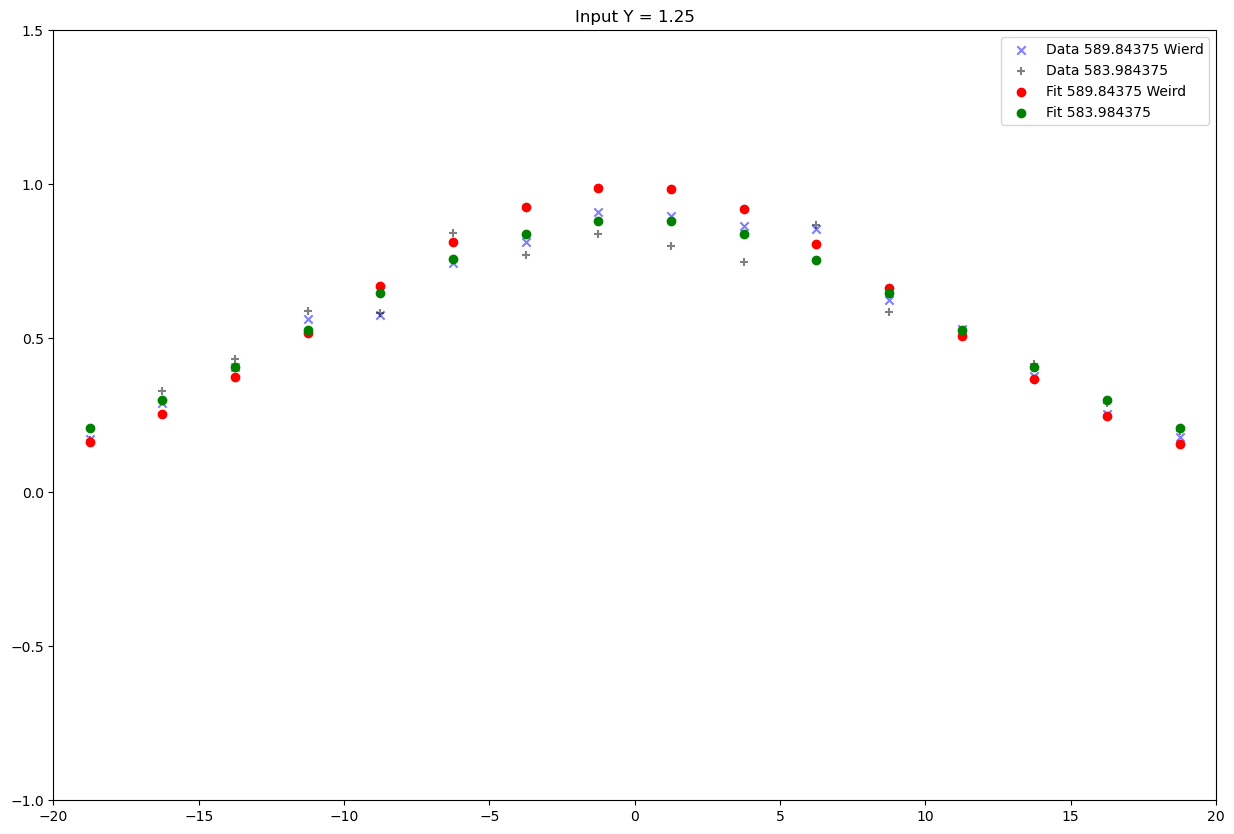

In [13]:
amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0


fly = '625'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits = np.load(ffile)

pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])
mbxlow = lowFreq.x_centers_grid[:,:,0].flatten()
mbylow = lowFreq.y_centers_grid[:,:,0].flatten()
mbVlow = lowFreq.V_LC_operation[:,:,0,1].flatten()
mbxHigh = higherFreq.x_centers_grid[:,:,0].flatten()
mbyHigh = higherFreq.y_centers_grid[:,:,0].flatten()
mbVHigh = higherFreq.V_LC_operation[:,:,0,11].flatten()
gooddatalow = np.isfinite(mbVlow)
gooddataHigh = np.isfinite(mbVHigh)
input_data_l=np.array([mbxlow[gooddatalow],mbylow[gooddatalow],mbVlow[gooddatalow]])
input_data_h=np.array([mbxHigh[gooddataHigh],mbyHigh[gooddataHigh],mbVHigh[gooddataHigh]])
G_popt_l=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data_l).x
G_popt_h=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data_h).x

gaussL= gaussianResultArray(G_popt_l, mbxlow, mbylow)
guassH= gaussianResultArray(G_popt_h, mbxHigh, mbyHigh)

#Plotting an Horizontal Slice 
horizontalGaussSliceL = getSliceGauss(gaussL, 'h')
horizontalGaussSliceH = getSliceGauss(guassH, 'h')
horizontalIndexL = get_slice(lowFreq,lowFreq.V_LC_operation[:,:,0,11],1.25,'h')
horizontalIndexH = get_slice(higherFreq,higherFreq.V_LC_operation[:,:,0,11],1.25,'h')
fig = plt.figure(figsize=(15,10))
plt.scatter(lowFreq.x_centers_grid[:,horizontalIndexL[0],0],lowFreq.V_LC_operation[:,horizontalIndexL[0],0,11], c = 'blue', label = 'Data 589.84375 Wierd', marker = 'x', alpha = 0.5 )
plt.scatter(higherFreq.x_centers_grid[:,horizontalIndexH[0],0],higherFreq.V_LC_operation[:,horizontalIndexH[0],0,11], c = 'black', label ='Data 583.984375', marker = '+', alpha = 0.5)
plt.scatter(horizontalGaussSliceL[0, :], horizontalGaussSliceL[2, :], c = 'red', label = 'Fit 589.84375 Weird')
plt.scatter(horizontalGaussSliceH[0, :], horizontalGaussSliceH[2, :], c = 'green', label ='Fit 583.984375')
plt.title('Input Y = 1.25')
plt.ylim(-1,1.5)
plt.xlim(-20,20)
plt.legend()
plt.show()